In [1]:
"""
Created on Wed Aug 4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")

2022-10-28 22:24:36.195300: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer(fn='../datasets/methane_air_master.csv')
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [4]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2022-10-28 22:24:49.955606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 22:24:50.350071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5169 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [ ]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dependants = 'NoDependants'
dataSetMethod = f'{inputType}_{dataType}_{dependants}'
opscaler=ipscaler="MinMaxScaler"# 'PositiveLogNormal'
#opscaler=None
ZmixPresent = 'N'
concatenateZmix = 'N'
kernel_constraint = 'Y'
kernel_regularizer = 'N'
activity_regularizer = 'N'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='mae'
exprExec.modelFactory.activation_func='selu'
exprExec.modelFactory.dropout_rate=0.0
exprExec.debug_mode = False
exprExec.use_dependants = True
exprExec.use_dynamic_pred = True
exprExec.epochs_override = 100
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

history = exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                           noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                           kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                           opscaler=opscaler, ipscaler=ipscaler)

## Results Plotting & Analysis

In [5]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
bestModel = exprExec.modelFactory.getEmbRegressor()
dm = experimentSettings['data_manager']
dp = dm.constants # god only knows why this is called "constants"
history = experimentSettings['history']
del experimentSettings['data_manager']
del experimentSettings['history'] # remove clutter from print

inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
print(f'\nexperimentSettings: {experimentSettings}')
experimentSettings['history'] = history # put it pack

len testing df:  3732
input names: ['input_1']
output names (before pruning): ['dynamic_source_prediction', 'static_source_prediction']
117/117 [==============================] - 1s 790us/step
['zmix', 'cpv1', 'cpv2', 'cpv3', 'cpv4', 'cpv5', 'cpv6', 'cpv7', 'cpv8', 'cpv9']

bestModel.input_shape: [(None, 53), (None, 1)]

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'RobustScaler', 'noOfCpv': 9, 'ZmixPresent': 'Y', 'concatenateZmix': 'Y', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'N', 'input_data_cols': ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2C

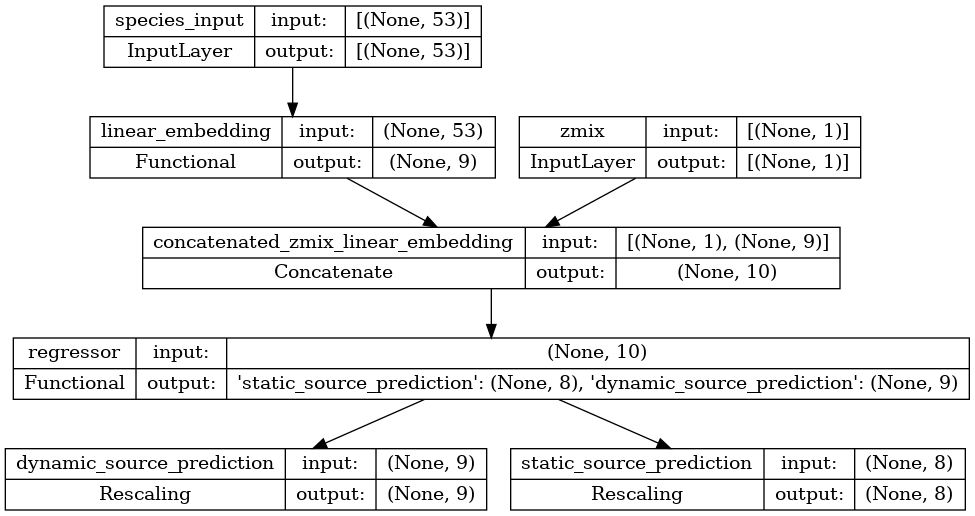

In [6]:
tf.keras.utils.plot_model(bestModel, show_shapes=True)

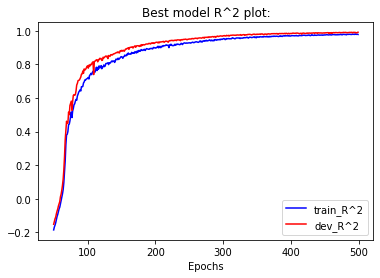

Best Model dev R^2 (combined):  0.9944306334943078
Best Model val static R^2: 0.9859598875045776
Best Model val dynamic R^2: 0.9855085015296936


In [27]:
import matplotlib.pyplot as plt

x_axis = np.arange(50, len(experimentSettings['history']['loss']))

plt.plot(x_axis, -np.array(experimentSettings['history']['loss'][50:])/2, color='blue')
plt.plot(x_axis, -np.array(experimentSettings['history']['val_loss'][50:])/2, color='red')
plt.xlabel('Epochs')
plt.legend(labels=['train_R^2', 'dev_R^2'])
plt.title('Best model R^2 plot:')
plt.savefig('best_model_R^2.pdf')
plt.show()

# Legacy compatibility
if 'emb_and_regression_model_R2' in experimentSettings['val_losses']:
    experimentSettings['val_losses']['static_source_prediction_R2'] = experimentSettings['val_losses']['emb_and_regression_model_R2']
    
print('Best Model dev R^2 (combined): ', experimentSettings['model_R2'])
print('Best Model val static R^2:', experimentSettings['val_losses']['static_source_prediction_R2'])
print('Best Model val dynamic R^2:', experimentSettings['val_losses']['dynamic_source_prediction_R2_split'])

117/117 [==============================] - 0s 3ms/step
cpv1; 1.515662e+05 +/- 4.216870e+03
cpv8; 1.443817e+05 +/- 5.052755e+03
zmix; 1.320148e+05 +/- 4.234465e+03
cpv3; 1.210033e+04 +/- 6.786674e+02
cpv7; 5.878437e+03 +/- 6.090274e+02
cpv6; 3.098361e+03 +/- 2.301644e+02
cpv5; 1.593257e+03 +/- 1.444251e+02
cpv4; 1.370582e+03 +/- 7.452547e+01
cpv2; 5.239544e+02 +/- 3.618141e+01


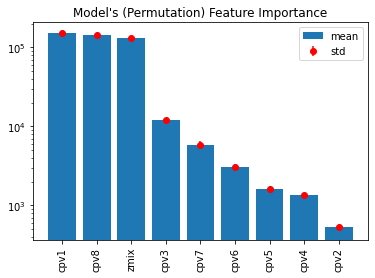

In [24]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

         zmix      cpv1      cpv2      cpv3      cpv4      cpv5      cpv6  \
min  0.000000  0.000270  0.000069  0.000073  0.000109  0.003120  0.000020   
25%  0.228928  0.011856  0.000507  0.001913  0.002062  0.008132  0.002333   
50%  0.420886  0.039292  0.001880  0.007438  0.008491  0.014460  0.008375   
75%  0.649811  0.057766  0.011408  0.015974  0.014080  0.018601  0.013092   
max  0.974047  0.068648  0.029959  0.023727  0.019523  0.035709  0.016285   

         cpv7      cpv8  
min  0.002228  0.014241  
25%  0.003218  0.036366  
50%  0.005559  0.050246  
75%  0.021977  0.071854  
max  0.051509  0.081854  
1/1 [==============================] - 0s 19ms/step


/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 13ms/step


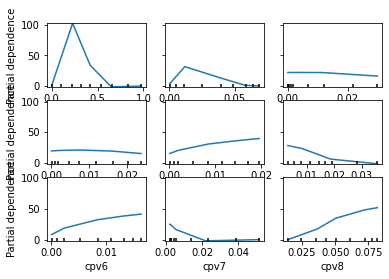

In [25]:
inspector.plot_partial_dependence()

#### Error Density by FlameId & XPos

584/584 [==============================] - 2s 3ms/step


Text(0.5, 1.0, 'Residual, Marginal Density plot:')

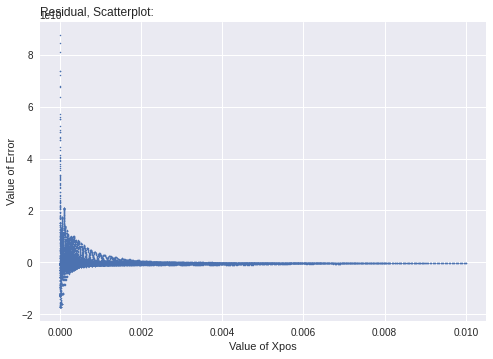

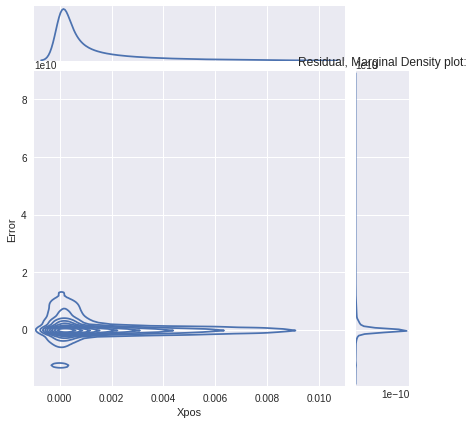

In [26]:
def getResiduals(Y,Y_pred):
    return Y-Y_pred

# TODO: Sanity check that this plots output ranges are correct? Seems like bug!
bestModel = exprExec.modelFactory.getEmbRegressor()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X, Y, Zmix, sources = dm.getAllData()
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})['static_source_prediction']

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, dm.souener_index]
souener_actual = opscaler.inverse_transform(Y)[:, dm.souener_index]

#residual/error
residuals = getResiduals(souener_actual,souener_pred)
Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"] = Xpos
plt_df["Error"] = residuals
# plot
plt.plot('Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Residual, Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')
plt.title('Residual, Marginal Density plot:')

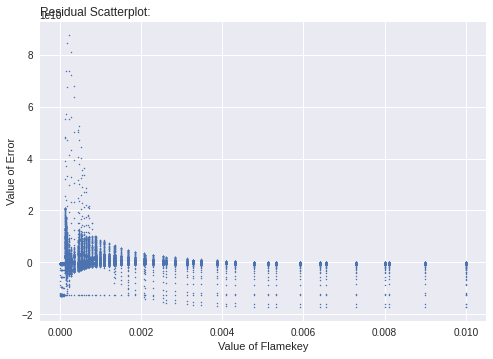

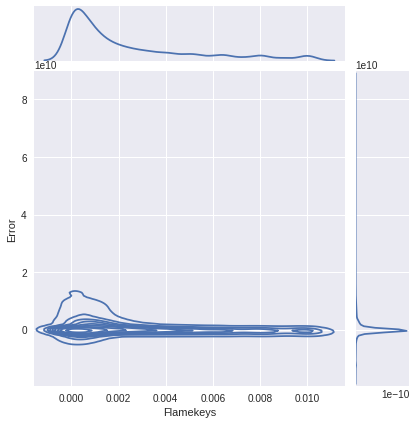

In [27]:
flamekeys = df['flame_key']

plt_df = pd.DataFrame()
plt_df["Flamekeys"] = flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Residual Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

Text(0.5, 1.0, 'Souener (scaled) histogram')

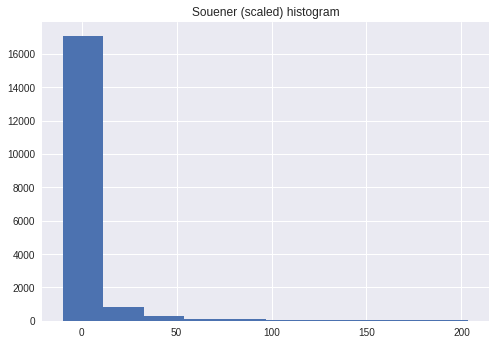

In [28]:
plt.hist(Y[:,0])
plt.title('Souener (scaled) histogram')

Text(0.5, 1.0, 'Souener_pred (scaled) histogram')

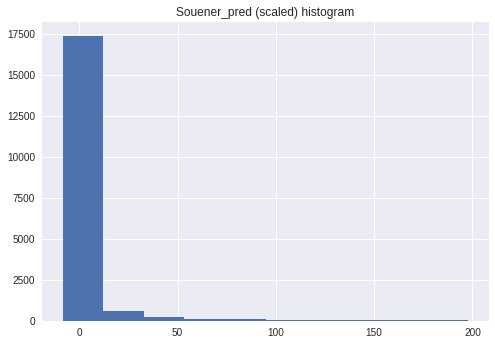

In [29]:
plt.hist(Y_pred[:,0])
plt.title('Souener_pred (scaled) histogram')